Using cpu device
Mean Squared Error on the test set: 35996.0410


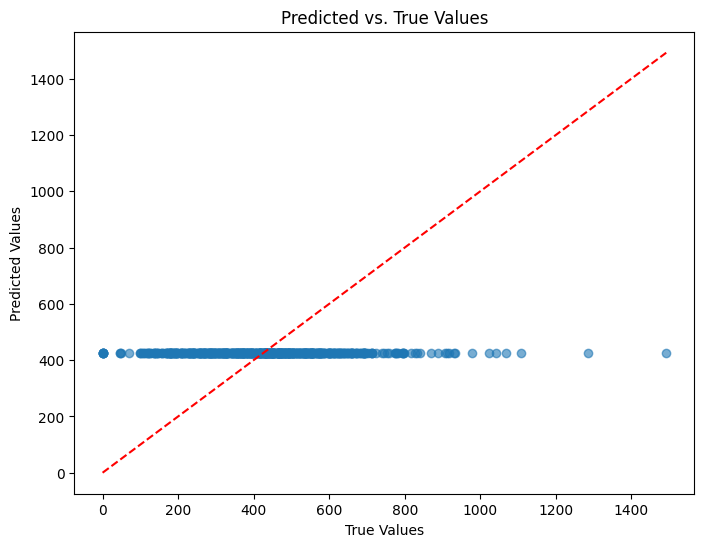

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import mean_squared_error

torch.manual_seed(123)


df = pd.read_csv(r"C:\Users\apresser\code\PRGS-Intro-to-Machine-Learning\data\processed\svi_covid.csv")

# Define the predictor and outcome columns
predictor_columns = ["EP_POV150", "EP_UNEMP", "EP_HBURD", "EP_NOHSDP", "EP_UNINSUR", 
                     "EP_AGE65", "EP_AGE17", "EP_DISABL", "EP_SNGPNT", "EP_LIMENG", 
                     "EP_MINRTY", "EP_MUNIT", "EP_MOBILE", "EP_CROWD", "EP_NOVEH", 
                     "EP_GROUPQ", "EP_NOINT"]
outcome_column = "total_deaths_per_100k"

# Define a Dataset Class
class PandasDataset(Dataset):
    def __init__(self, dataframe, predictors, outcome):
        x = np.array(dataframe[predictors].values).reshape(-1, len(predictors))
        y = np.array(dataframe[outcome].values).reshape(-1, 1)
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Load your data into the PandasDataset class
dataset = PandasDataset(df, predictor_columns, outcome_column)

# Split the data into training and testing sets
train_perc = 0.8  # 80% of the data will be used for training
train_size = int(train_perc * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set up device for training
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define the Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(predictor_columns), 10),  # Input layer size based on number of predictors
            nn.ReLU(),                              # Hidden layer with 10 nodes
            nn.Linear(10, 1)                        # Output layer with a single node for regression
        )

    def forward(self, x):
        estimates = self.linear_relu_stack(x)
        return estimates

model = NeuralNetwork().to(device)  # Load the model onto the appropriate device

# Define the Loss Function
loss_fn = nn.MSELoss()

# Define the Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Define the Training and Testing Functions
def train(dataloader, model, loss_fn, optimizer, losses):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    train_loss /= num_batches
    losses.append(train_loss)

def test(dataloader, model, loss_fn, losses):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    losses.append(test_loss)

# Train the Neural Network
batch_size = 64  # Number of observations to use in each iteration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []
epochs = 100  # Set a reasonable number of epochs to start with
for t in range(epochs):
    train(train_loader, model, loss_fn, optimizer, train_losses)
    test(test_loader, model, loss_fn, test_losses)


# Switch model to evaluation mode
model.eval()

# Initialize lists to store predictions and true values
predictions = []
true_values = []

# No need to compute gradients during evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        pred = model(X_test)  # Make predictions
        predictions.extend(pred.squeeze().tolist())  # Add predictions to list
        true_values.extend(y_test.squeeze().tolist())  # Add true values to list

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error on the test set: {mse:.4f}")

# Plot predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')  # Diagonal line for reference
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values")
plt.show()


Mean Squared Error on the test set: 20725.8363


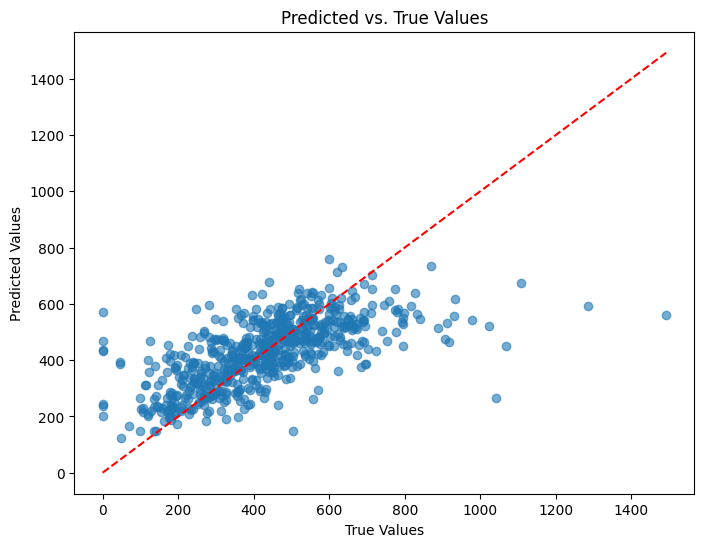

In [2]:
class ComplexNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(len(predictor_columns), 64),  # First hidden layer with 64 nodes
            nn.LeakyReLU(negative_slope=0.01),      # LeakyReLU activation
            nn.Linear(64, 32),                      # Second hidden layer with 32 nodes
            nn.LeakyReLU(negative_slope=0.01),      # LeakyReLU activation
            nn.Linear(32, 16),                      # Third hidden layer with 16 nodes
            nn.LeakyReLU(negative_slope=0.01),      # LeakyReLU activation
            nn.Linear(16, 1)                        # Output layer with a single node for regression
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

model = ComplexNeuralNetwork().to(device)  # Load the model onto the appropriate device

# Define the Loss Function
loss_fn = nn.MSELoss()

# Define the Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Using Adam optimizer

# Define the Training and Testing Functions
def train(dataloader, model, loss_fn, optimizer, losses):
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
    train_loss /= num_batches
    losses.append(train_loss)

def test(dataloader, model, loss_fn, losses):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    losses.append(test_loss)

# Train the Neural Network
batch_size = 64  # Number of observations to use in each iteration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_losses = []
test_losses = []
epochs = 100  # Set a reasonable number of epochs
for t in range(epochs):
    train(train_loader, model, loss_fn, optimizer, train_losses)
    test(test_loader, model, loss_fn, test_losses)

# Switch model to evaluation mode
model.eval()

# Initialize lists to store predictions and true values
predictions = []
true_values = []

# No need to compute gradients during evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        pred = model(X_test)  # Make predictions
        predictions.extend(pred.squeeze().tolist())  # Add predictions to list
        true_values.extend(y_test.squeeze().tolist())  # Add true values to list

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error on the test set: {mse:.4f}")

# Plot predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(true_values, predictions, alpha=0.6)
plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--')  # Diagonal line for reference
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values")
plt.show()

In [3]:
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
# Yes running it in the cloud seemed a lot faster. I don't recall exactly how long it took to run HW #5 but I remember it seemed like much longer than this. These cells completed running in less than 10 seconds each. I think the computational speed was faster because the computations could have been split up and parallelized by running them on an external server, which has more computational cores.